In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
import time
import struct
import tensorflow as tf
import random as rd

from array import array
# import keras._tf_keras.keras as keras 
# from keras._tf_keras.keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

# my project
from module.conf import PROJECT_DIR

# matplotlib.use("QTAgg")
%matplotlib inline

1. Load data:
- Train data: 60k 28x28 images
- Test data: 

In [2]:
mnist_path = "/data/sample/mnist"
training_images_filepath = "".join([PROJECT_DIR, mnist_path, "/train-images.idx3-ubyte"])
training_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/train-labels.idx1-ubyte"])
test_images_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-images.idx3-ubyte"])
test_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-labels.idx1-ubyte"])

def read_images_labels(images_filepath, labels_filepath) -> tuple:
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        # labels = array("B", file.read())
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())       
     
    images = []
    # for i in range(size):
    #     images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        # images[i][:] = img
        images.append(img)
    
    return images, labels

def load_data() -> tuple:
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (x_train, y_train),(x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

In [3]:
# print(f"{type(X_train[0])}")
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()


In [111]:
X_train = np.asarray(X_train)/255
y_train = np.asarray(y_train)
X_test  = np.asarray(X_test)/255
y_test  = np.asarray(y_test)

KeyboardInterrupt: 

In [103]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Flatten(input_shape=(28, 28,)),
    tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=128, activation=tf.keras.activations.hard_sigmoid),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
])

In [104]:
# predictions = model(X_train[0]).numpy()
# predictions
# tf.nn.softmax(predictions).numpy()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                25120     
                                                                 
 dense_19 (Dense)            (None, 128)               4224      
                                                                 
 dense_20 (Dense)            (None, 10)                1290      
                                                                 
Total params: 30,634
Trainable params: 30,634
Non-trainable params: 0
_________________________________________________________________


In [105]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.CategoricalHinge()
# loss_fn = tf.keras.losses.MeanSquaredLogarithmicError()
# model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=["accuracy"])

In [109]:
# X_train, X_test = np.asarray(X_train) / 255.0, np.asarray(X_test) / 255.0
# print(X_test)
model.fit(x=X_train, y=y_train, epochs=50, batch_size=600, workers=8, use_multiprocessing=False)

Epoch 1/50
100/100 [==============================] - 0s 3ms/step - loss: 0.3226 - accuracy: 0.9109
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 0.2736 - accuracy: 0.9222
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 0.2436 - accuracy: 0.9298
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 0.2220 - accuracy: 0.9358
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.9422
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9484
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.9527
Epoch 8/50
100/100 [==============================] - 0s 2ms/step - loss: 0.1519 - accuracy: 0.9558
Epoch 9/50
100/100 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9584
Epoch 10/50
100/100 [==============================] - 0s 2ms/step - loss: 0.1311 - accuracy: 0.9615

In [110]:
model.evaluate(X_test,  y_test, verbose=2)
c = 0
cp = 0
for i in range(100):
    test_indx = rd.randint(0, len(y_test)-1)
    x_test_ = np.asarray([X_test[test_indx]])

    # test_indx = rd.randint(0, len(y_train)-1)
    # x_test_ = np.asarray([X_train[test_indx]])

    result = model.predict(x=x_test_, verbose=0)
    # result = tf.nn.softmax(result).numpy()
    y_test_ = y_test
    # if result.max() >= 0.5:
    if result.argmax() != y_test_[test_indx]:
        c+=1
        print(f"- [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} solve:{y_test_[test_indx]}")
    else:
        print(f"+ [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} solve:{y_test_[test_indx]}")
    # else:
    #     print(f"= [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} solve:{y_test_[test_indx]}")
    #     cp+=1
print(f"error: {c} can not pred:{cp}")

313/313 - 0s - loss: 0.0964 - accuracy: 0.9735 - 166ms/epoch - 530us/step
+ [0]:img[5850]:[[2.7108197e-06 1.9385432e-05 3.6754348e-06 9.9989188e-01 3.7129229e-08
  2.2058550e-06 1.1915336e-09 2.0540094e-08 2.9353145e-05 5.0714883e-05]]
pred:0.9998918771743774
predict:3 solve:3
+ [1]:img[9018]:[[1.5838665e-07 3.7183793e-04 9.9794537e-01 9.5586547e-05 1.3206399e-06
  4.7588534e-07 5.2331888e-08 1.5850893e-03 1.0511897e-07 1.4557484e-11]]
pred:0.9979453682899475
predict:2 solve:2
+ [2]:img[7398]:[[9.1261285e-08 3.8208946e-06 2.7474965e-07 9.9979991e-01 1.4592685e-08
  9.1561869e-06 2.2514375e-12 7.6135976e-08 1.5103265e-04 3.5562574e-05]]
pred:0.999799907207489
predict:3 solve:3
+ [3]:img[1794]:[[9.8625988e-01 1.0706133e-03 7.3504318e-03 1.2445984e-05 1.3696276e-05
  6.4442342e-05 5.1994501e-03 6.8464501e-06 2.7109304e-06 1.9488734e-05]]
pred:0.9862598776817322
predict:0 solve:0
+ [4]:img[2608]:[[2.6827936e-07 8.3336505e-05 2.0077766e-06 8.2578708e-06 1.9815013e-06
  9.3720664e-06 2.22871

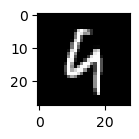

In [108]:
def show_image(img_data: np.ndarray) -> tuple:
    fig, axes = plt.subplots(figsize=(1.60, 1.20))
    axes.imshow(X=img_data, cmap="gray")
    return fig, axes

# print(y_test[5854])
show_image(X_test[4823])
plt.show()

In [97]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

Num GPUs Available:  0


Trong quá trình **backpropagation**, khi sử dụng hàm softmax trong lớp đầu ra của một mạng nơ-ron, ta cần tính toán gradient của hàm mất mát (thường là categorical cross-entropy) đối với các trọng số. Điều này yêu cầu tính toán đạo hàm của hàm softmax.

### 1. **Hàm Softmax và Hàm Mất Mát Cross-Entropy**

Giả sử đầu ra của mạng nơ-ron là một vector \( \mathbf{z} = [z_1, z_2, \dots, z_n] \). Hàm softmax được định nghĩa như sau:

\[
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
\]

Giả sử nhãn đúng là \( y \), hàm mất mát cross-entropy có dạng:

\[
L = -\sum_{i=1}^{n} y_i \log(\sigma(z_i))
\]

### 2. **Đạo Hàm Của Hàm Mất Mát Đối Với Đầu Ra Của Softmax**

Để thực hiện backpropagation, ta cần tính đạo hàm của hàm mất mát \( L \) đối với mỗi đầu ra của softmax \( z_i \):

\[
\frac{\partial L}{\partial z_i}
\]

Sử dụng quy tắc dây chuyền, ta có:

\[
\frac{\partial L}{\partial z_i} = \sum_{j=1}^{n} \frac{\partial L}{\partial \sigma(z_j)} \cdot \frac{\partial \sigma(z_j)}{\partial z_i}
\]

#### 2.1 **Đạo Hàm Của Hàm Mất Mát Với Softmax**

Đạo hàm của hàm mất mát \( L \) đối với đầu ra của softmax \( \sigma(z_j) \) là:

\[
\frac{\partial L}{\partial \sigma(z_j)} = \sigma(z_j) - y_j
\]

#### 2.2 **Đạo Hàm Của Softmax**

Đạo hàm của hàm softmax được tính như sau:

\[
\frac{\partial \sigma(z_j)}{\partial z_i} = 
\begin{cases} 
\sigma(z_i) \cdot (1 - \sigma(z_i)) & \text{nếu } i = j \\
-\sigma(z_i) \cdot \sigma(z_j) & \text{nếu } i \neq j 
\end{cases}
\]

### 3. **Vectorization (Tính Toán Dạng Vector)**

Trong thực hành, tính toán đạo hàm của hàm softmax được thực hiện thông qua vectorization để tối ưu hóa hiệu suất. Giả sử \( \mathbf{\sigma} \) là vector chứa các giá trị softmax \( \sigma(z_1), \sigma(z_2), \dots, \sigma(z_n) \), ta có:

\[
\frac{\partial \mathbf{\sigma}}{\partial \mathbf{z}} = \text{Jacobian}(\mathbf{\sigma}) = \mathbf{S} - \mathbf{\sigma} \cdot \mathbf{\sigma}^T
\]

trong đó:

- \( \mathbf{S} \) là ma trận chéo (diagonal matrix) với các phần tử \( \sigma(z_i) \) trên đường chéo chính.
- \( \mathbf{\sigma} \cdot \mathbf{\sigma}^T \) là tích ngoài (outer product) của vector \( \mathbf{\sigma} \).

Cụ thể hơn:

\[
\text{Jacobian}(\mathbf{\sigma}) = \text{diag}(\sigma) - \sigma \cdot \sigma^T
\]

### 4. **Gradient Đối Với Vector Đầu Ra**

Cuối cùng, gradient của hàm mất mát đối với vector \( \mathbf{z} \) (đầu ra trước softmax) có thể được biểu diễn dưới dạng vectorized:

\[
\frac{\partial L}{\partial \mathbf{z}} = \mathbf{\sigma} - \mathbf{y}
\]

Đây là dạng vectorized của gradient, rất quan trọng trong quá trình huấn luyện mô hình với backpropagation vì nó cho phép tính toán gradient một cách hiệu quả, đặc biệt là khi làm việc với các tập dữ liệu lớn và các mô hình có nhiều lớp.

### Tóm Lược

- **Đạo hàm của hàm softmax** có thể được biểu diễn dưới dạng ma trận Jacobian.
- Trong quá trình **backpropagation**, gradient của hàm mất mát đối với đầu ra trước softmax \( z_i \) có dạng vectorized: \( \frac{\partial L}{\partial \mathbf{z}} = \mathbf{\sigma} - \mathbf{y} \).
- Vectorization giúp tính toán gradient nhanh chóng và hiệu quả hơn khi huấn luyện các mô hình học sâu.